In [40]:
from random import shuffle
import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn

mms = MinMaxScaler()
# pca = PCA(n_components=8)

mnist = fetch_openml('mnist_784')
X_orig, y_orig = mnist["data"], mnist["target"]

X_orig = mms.fit_transform(np.array(X_orig).astype(np.float32))
y_orig = np.array(y_orig).astype(np.uint8)
target_digit1 = 3
target_digit2 = 8

target_digit1_xdata = X_orig[y_orig == target_digit1]
target_digit2_xdata = X_orig[y_orig == target_digit2]
target_digit1_ydata = y_orig[y_orig == target_digit1]
target_digit2_ydata = y_orig[y_orig == target_digit2]
X = np.concatenate((target_digit1_xdata, target_digit2_xdata), axis=0)
y = np.concatenate((target_digit1_ydata, target_digit2_ydata), axis=0)

y = np.where(y == target_digit1, -1, 1)

# reduce the dimensions of X
# X = pca.fit_transform(X)
# scale to 0/1
X = mms.fit_transform(X)

# # add on the bias
# X = np.concatenate([np.ones_like(X[:, :1]), X],axis=-1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# pca.fit(X_train)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(8379, 784) (2793, 784) (2794, 784)
(8379,) (2793,) (2794,)


In [42]:
X_train = X_train
y_train = y_train

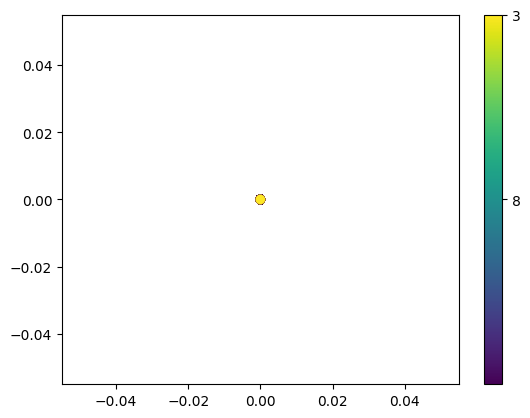

In [43]:
# pca2 = PCA(n_components=2)
# plotx = pca.fit_transform(X_train)

formatter = plt.FuncFormatter(lambda i, *args: np.where(y_train[i] == 1, target_digit2, target_digit1))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.colorbar(ticks=[0, 1], format=formatter)
# plt.xlabel(iris.feature_names[x_index])
# plt.ylabel(iris.feature_names[y_index])
plt.show()

In [44]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
device = 'cpu'
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.Tensor(y_test).to(device)
X_val = torch.Tensor(X_val).to(device)
y_val = torch.Tensor(y_val).to(device)
train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=1024)
test_dl = TensorDataset(X_test, y_test)
val_dl = TensorDataset(X_val, y_val)


In [45]:
class LinearSVM(nn.Module):
    def __init__(self, dim, C=1.0, bias=True):
        super().__init__()
        self.dim = dim
        self.w = nn.Parameter(torch.rand(self.dim))
        self.C = C
        self.b = nn.Parameter(torch.rand(1)) if bias else None

    def forward(self, X):                             # scores s = w^T x + b
        s = X @ self.w
        return s + self.b if self.b is not None else s

    def svm_loss(self, X, y, C=None, regularize_bias=False):
        C = C or self.C
        y = y.to(self.w.dtype)                          # y in {-1,+1}, float
        s = self(X)
        hinge = torch.clamp(1.0 - y * s, min=0.0)
        data_term = hinge.pow(2).mean()

        reg = 0.5 * (model.w @ model.w)

        if regularize_bias and (model.b is not None):
            reg = reg + 0.5 * (model.b * model.b)

        return reg + C * data_term

C = 1.0

lr = 1e-2
num_epochs = 10


dim = X_train.size(1)
model = LinearSVM(dim, C=1.0).to(device)
opt = torch.optim.SGD(model.parameters(), lr=2e-2)

num_epochs = 2000
sb = tqdm(range(num_epochs))
tl = []

for epoch in sb:
    for Xb, yb in train_dl:
        loss = model.svm_loss(Xb, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()

    if epoch % 10 == 0:
        with torch.no_grad():
            loss = model.svm_loss(X_val, y_val)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])


100%|██████████| 2000/2000 [01:12<00:00, 27.45it/s, loss=0.324]


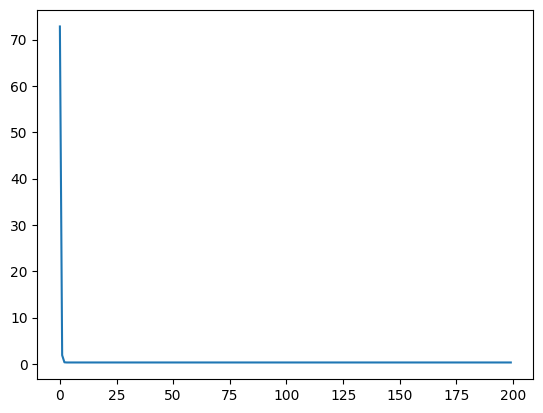

In [14]:
from matplotlib import pyplot as plt
tlnp = np.array(tl)
tlnp = tlnp
plt.plot(tlnp)
plt.show()

In [15]:
print(model.w, model.b)

Parameter containing:
tensor([ 3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,  3.5032e-44,
         3.5032e-44, -1.7086e

In [16]:
y_pred = (X_test @ model.w > 0) * 1.0


In [17]:
y_test_np = (y_test.detach().numpy() + 1.0)/2
y_pred_np = y_pred.detach().numpy()

In [18]:
from sklearn import metrics
print(metrics.accuracy_score(y_test_np, y_pred_np))
print(metrics.precision_score(y_test_np, y_pred_np))
print(metrics.recall_score(y_test_np, y_pred_np))
metrics.confusion_matrix(y_test_np, y_pred_np)

0.9301825993555317
0.881201044386423
0.9904622157006603


array([[1248,  182],
       [  13, 1350]])

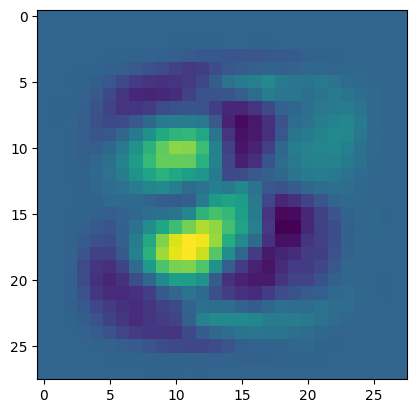

In [19]:
plt.imshow(model.w.detach().numpy().reshape((28,28)))

# Now to break it

In [20]:
for param in model.parameters():
    param.requires_grad = False


  1%|▏         | 130/10000 [00:00<00:03, 3115.41it/s, loss=1.11]


Finished!
0.008648079


  1%|          | 70/10000 [00:00<00:03, 3180.50it/s, loss=1.05]


Finished!
0.009808619


  1%|          | 70/10000 [00:00<00:03, 2964.47it/s, loss=1.08]


Finished!
0.0018400052


  2%|▏         | 160/10000 [00:00<00:03, 3166.26it/s, loss=1.11]


Finished!
0.0053431396


  1%|          | 100/10000 [00:00<00:03, 3047.65it/s, loss=1.1]


Finished!
0.005685364


  1%|          | 100/10000 [00:00<00:03, 3290.22it/s, loss=1.1]


Finished!
0.0015102671


100%|██████████| 10000/10000 [00:02<00:00, 3967.93it/s, loss=4.48]


3.4701372e-07


  1%|          | 80/10000 [00:00<00:03, 3178.23it/s, loss=1.1]


Finished!
0.010024225


  1%|          | 70/10000 [00:00<00:03, 3094.06it/s, loss=1.1]


Finished!
0.012490285


  1%|          | 100/10000 [00:00<00:03, 3259.84it/s, loss=1.09]


Finished!
0.009832216


100%|██████████| 10000/10000 [00:02<00:00, 3838.52it/s, loss=1.07]


0.0005168031


  1%|          | 60/10000 [00:00<00:03, 3142.82it/s, loss=1.11]


Finished!
0.0019210234


  1%|          | 70/10000 [00:00<00:03, 3237.59it/s, loss=1.07]


Finished!
0.010775464


  1%|          | 100/10000 [00:00<00:02, 3441.28it/s, loss=1.09]


Finished!
0.0062042177


  1%|          | 80/10000 [00:00<00:03, 3193.59it/s, loss=1.08]

Finished!
0.004587953



  0%|          | 50/10000 [00:00<00:03, 3146.04it/s, loss=1.09]


Finished!
0.0006865724


  1%|          | 90/10000 [00:00<00:03, 3176.41it/s, loss=1.07]


Finished!
0.008497111


  1%|          | 70/10000 [00:00<00:03, 3269.79it/s, loss=1.09]


Finished!
0.007796313


  1%|          | 70/10000 [00:00<00:03, 3195.80it/s, loss=1.11]


Finished!
0.005475994


  1%|          | 80/10000 [00:00<00:02, 3310.16it/s, loss=1.11]


Finished!
0.0009705163


  1%|          | 70/10000 [00:00<00:03, 3036.08it/s, loss=1.09]

Finished!
0.008211596



/var/folders/sh/x7gvx6517mx2_19qkh1b6y0w0000gn/T/ipykernel_11231/4105722493.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))
  0%|          | 50/10000 [00:00<00:03, 2867.78it/s, loss=1.07]


Finished!
0.00069993344


  1%|          | 70/10000 [00:00<00:03, 3092.56it/s, loss=1.1]


Finished!
0.0058143153


  1%|          | 70/10000 [00:00<00:03, 3194.44it/s, loss=1.1]


Finished!
0.005030154


100%|██████████| 10000/10000 [00:02<00:00, 3728.81it/s, loss=2.03]


3.066852e-06


100%|██████████| 10000/10000 [00:02<00:00, 3651.54it/s, loss=1.09]


0.0067445254


100%|██████████| 10000/10000 [00:02<00:00, 3923.92it/s, loss=1.11]


0.007354154


  1%|          | 70/10000 [00:00<00:02, 3319.40it/s, loss=1.1]


Finished!
0.0066185985


  1%|          | 80/10000 [00:00<00:03, 3221.65it/s, loss=1.06]


Finished!
0.013093952


  1%|          | 70/10000 [00:00<00:03, 3184.43it/s, loss=1.11]


Finished!
0.0068815434


  1%|          | 100/10000 [00:00<00:02, 3325.75it/s, loss=1.11]


Finished!
0.0107451165


  1%|          | 90/10000 [00:00<00:03, 3205.81it/s, loss=1.11]

Finished!
0.0049744053



  1%|          | 60/10000 [00:00<00:03, 3159.39it/s, loss=1.05]


Finished!
0.004364641


  0%|          | 50/10000 [00:00<00:03, 2952.24it/s, loss=1.1]


Finished!
0.00023287881


  0%|          | 50/10000 [00:00<00:03, 3171.21it/s, loss=1.1]


Finished!
0.00087612326


100%|██████████| 10000/10000 [00:02<00:00, 4070.00it/s, loss=0.92]


0.000113632836


  1%|          | 90/10000 [00:00<00:03, 3146.20it/s, loss=1.08]


Finished!
0.004965599


  1%|          | 70/10000 [00:00<00:03, 3066.94it/s, loss=1.1]


Finished!
0.0019483527


  1%|          | 70/10000 [00:00<00:03, 3136.33it/s, loss=1.09]


Finished!
0.009225383


100%|██████████| 10000/10000 [00:02<00:00, 4029.74it/s, loss=1.01]


0.0018582399


  1%|          | 70/10000 [00:00<00:03, 3003.26it/s, loss=1.09]


Finished!
0.011755396


  1%|          | 110/10000 [00:00<00:03, 3270.78it/s, loss=1.1]


Finished!
0.0107189175


100%|██████████| 10000/10000 [00:02<00:00, 4096.61it/s, loss=1.06]


0.00022186321


100%|██████████| 10000/10000 [00:02<00:00, 3542.43it/s, loss=1.01]


0.0011776893


  1%|          | 70/10000 [00:00<00:03, 3124.18it/s, loss=1.1]


Finished!
0.0047048903


  1%|          | 80/10000 [00:00<00:03, 3180.15it/s, loss=1.07]


Finished!
0.009307493


  1%|          | 100/10000 [00:00<00:03, 3210.19it/s, loss=1.1]

Finished!
0.0063846647



100%|██████████| 10000/10000 [00:02<00:00, 4098.58it/s, loss=1.02]


0.00018010392


  1%|          | 60/10000 [00:00<00:03, 2914.30it/s, loss=1.05]


Finished!
0.0033281469


  1%|          | 90/10000 [00:00<00:02, 3304.31it/s, loss=1.1]


Finished!
0.010756255


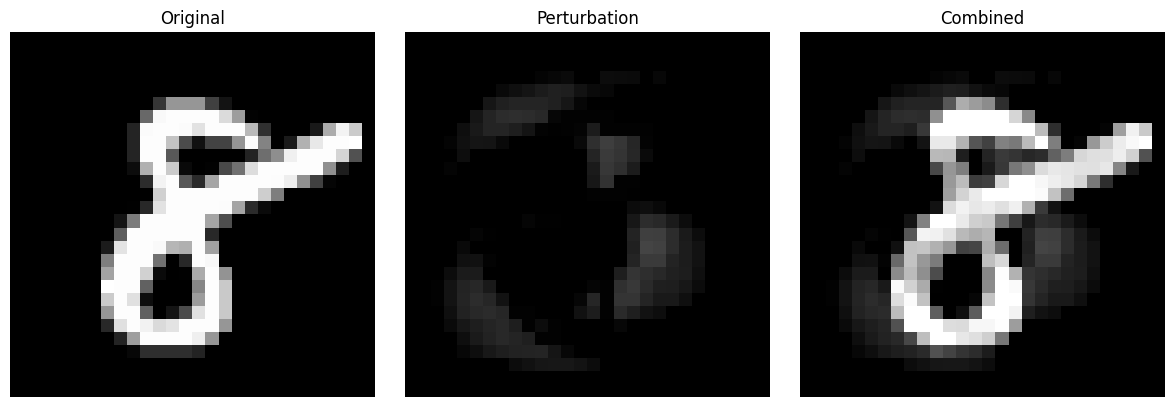

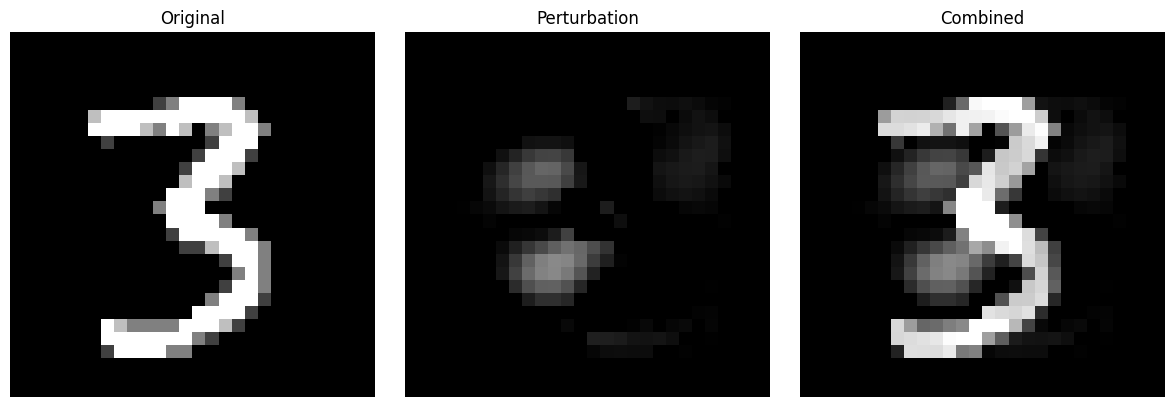

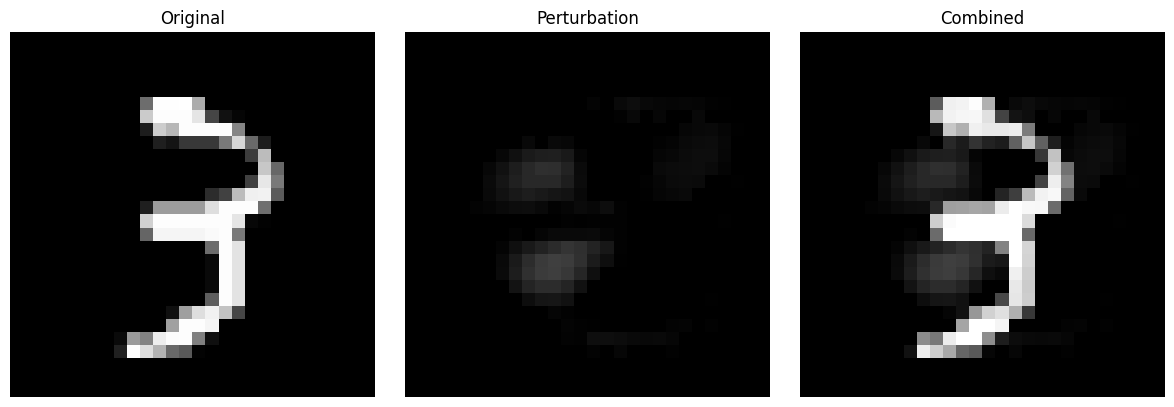

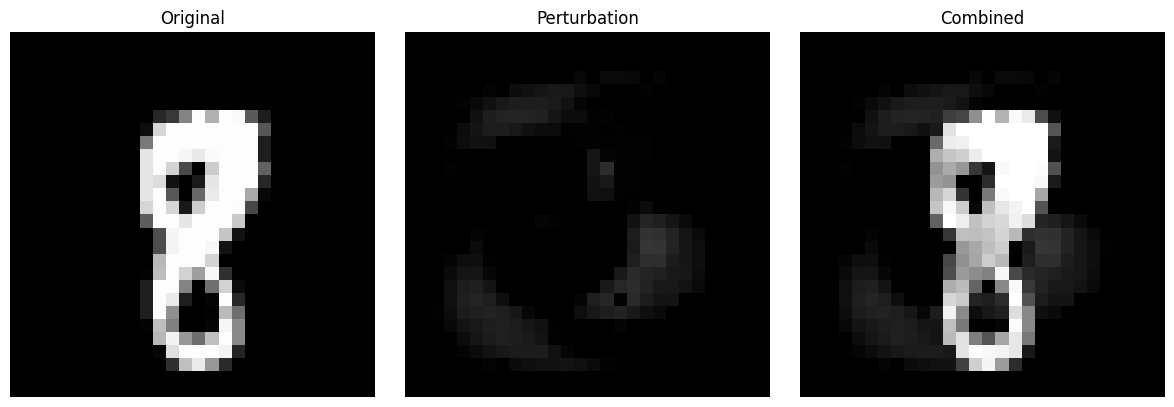

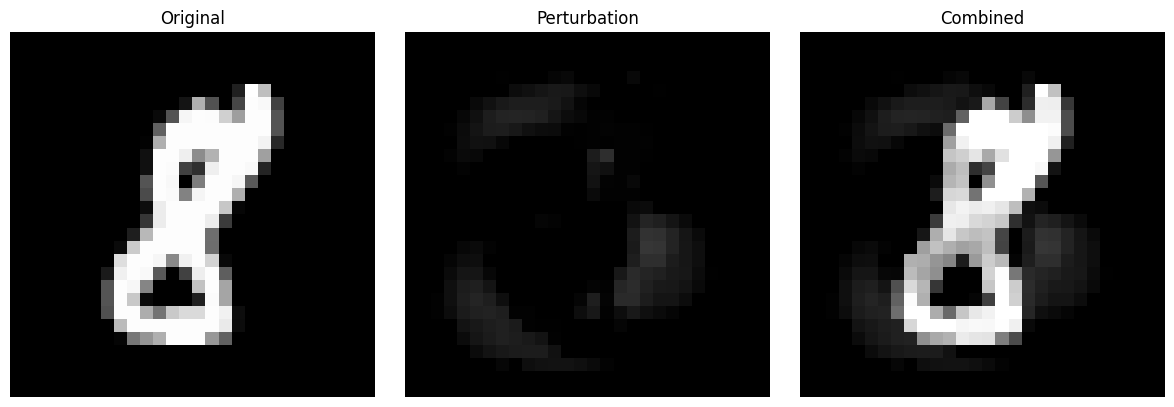

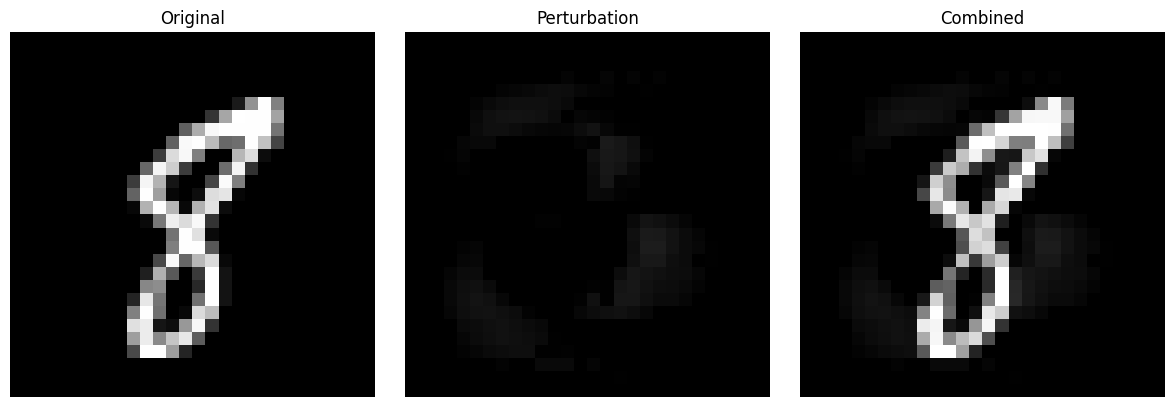

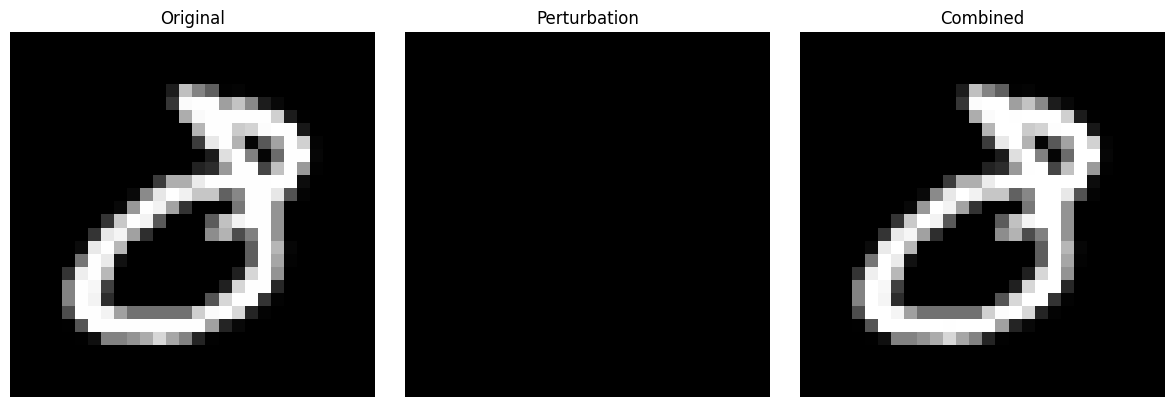

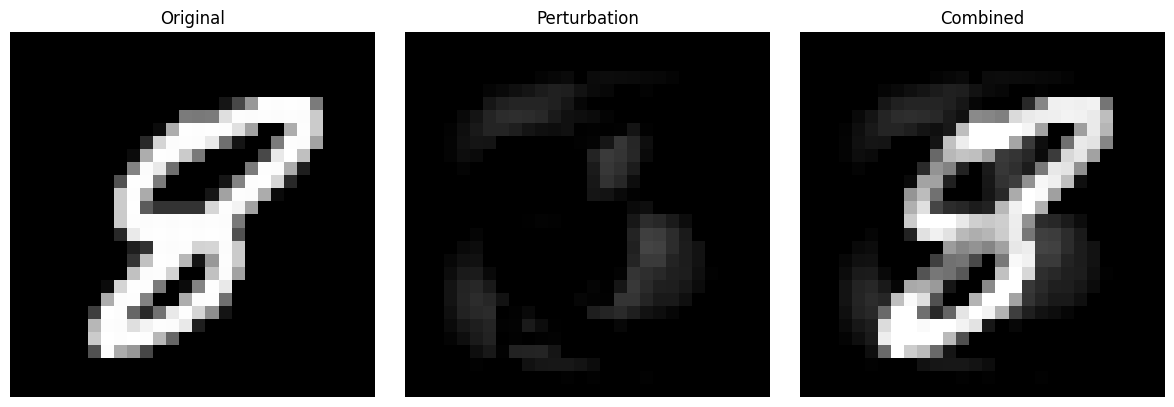

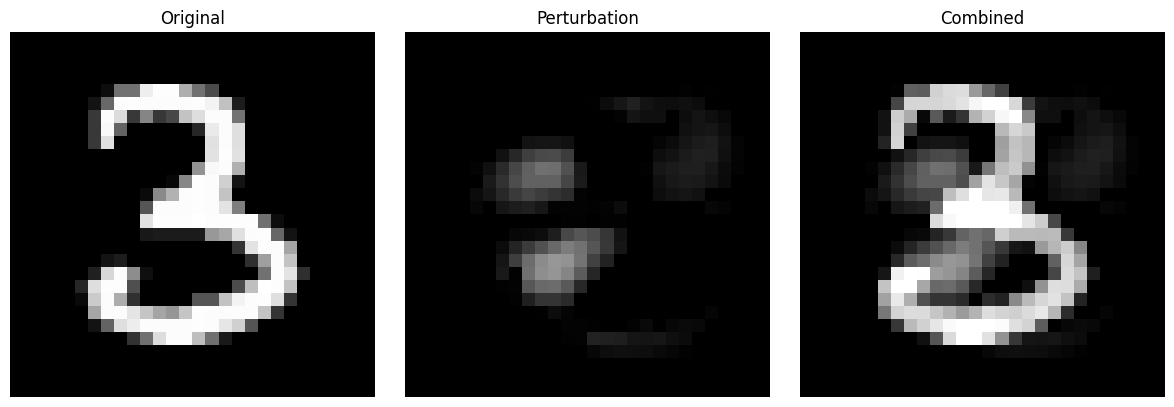

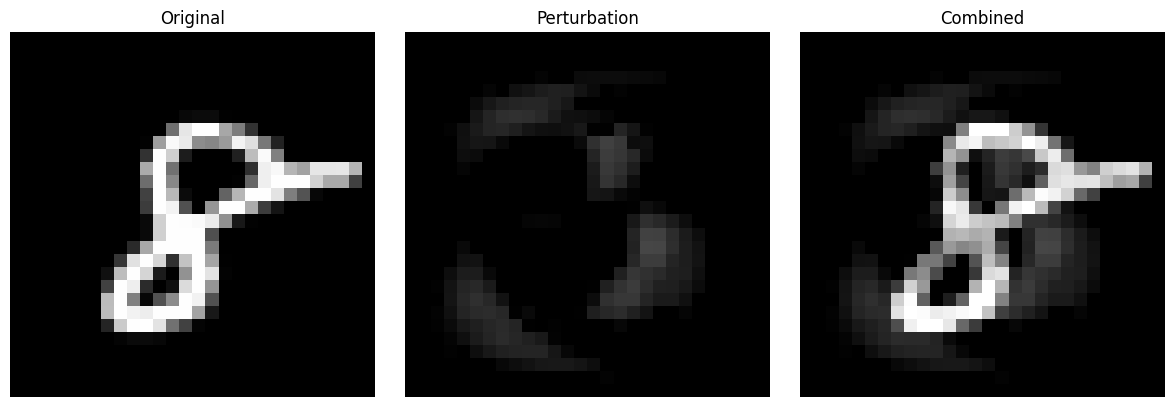

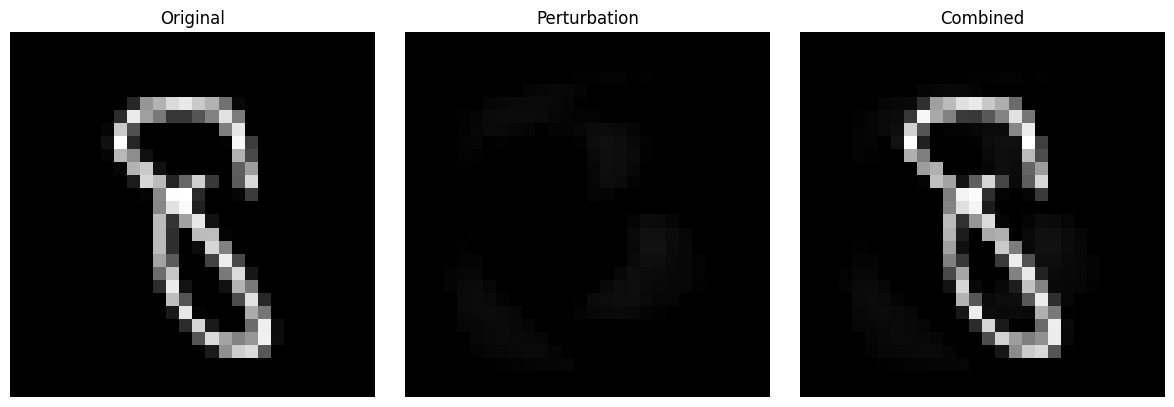

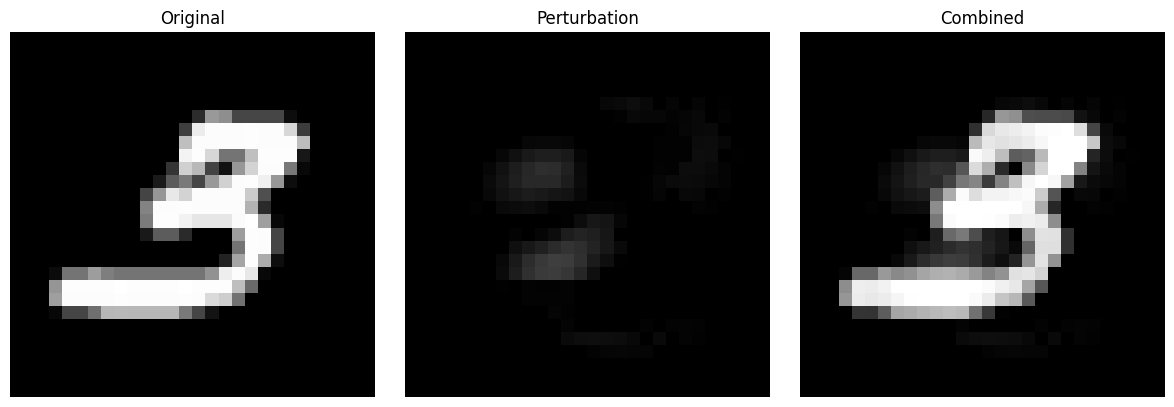

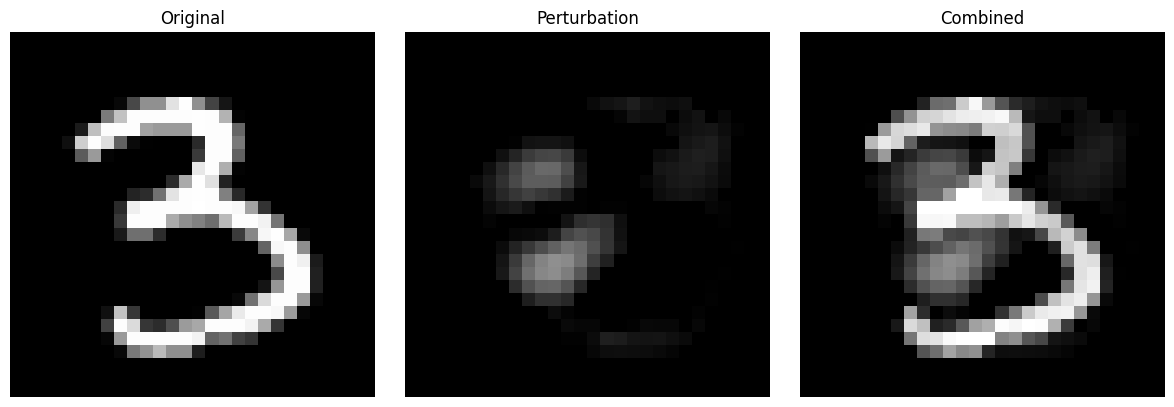

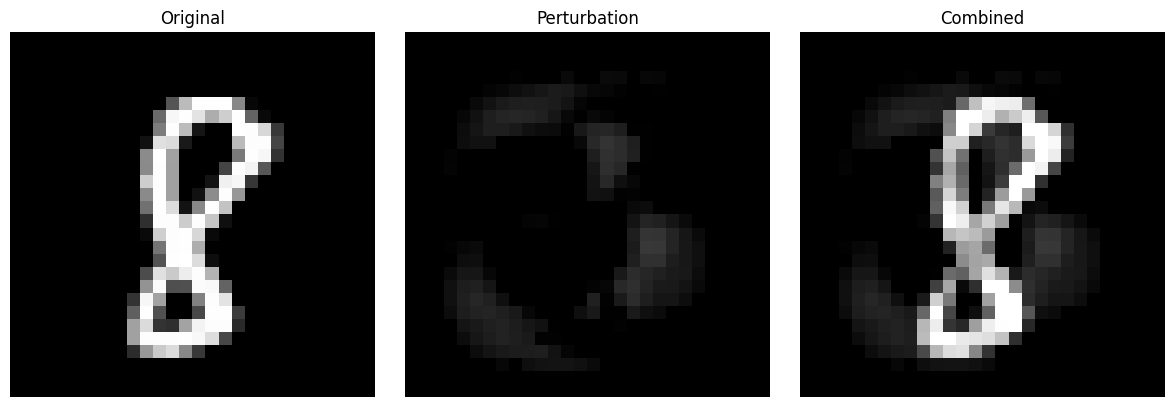

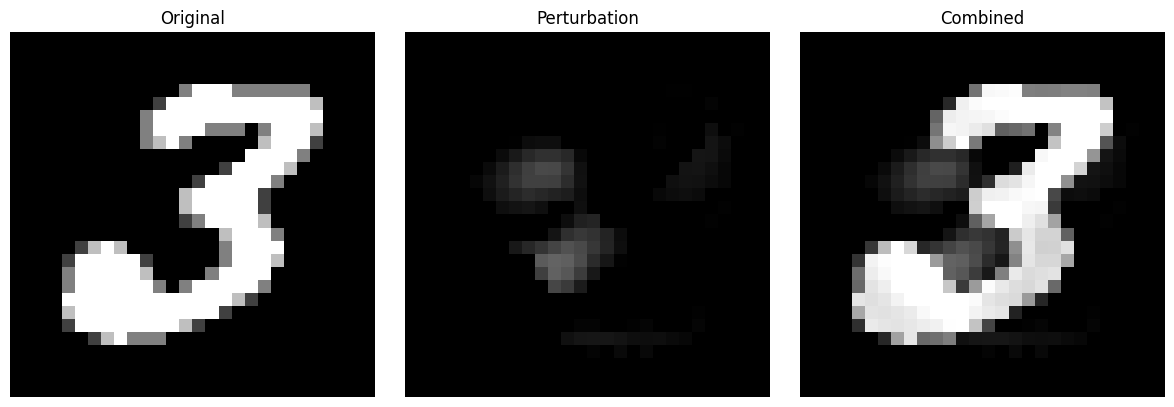

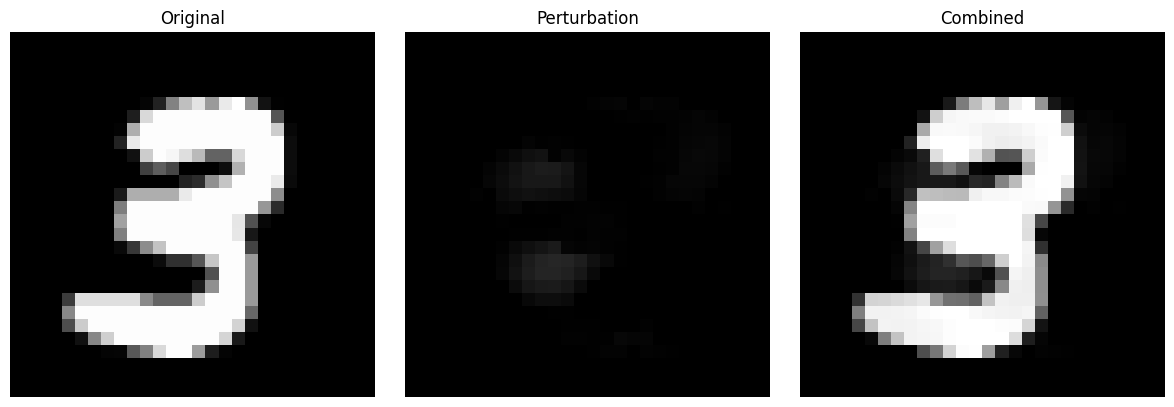

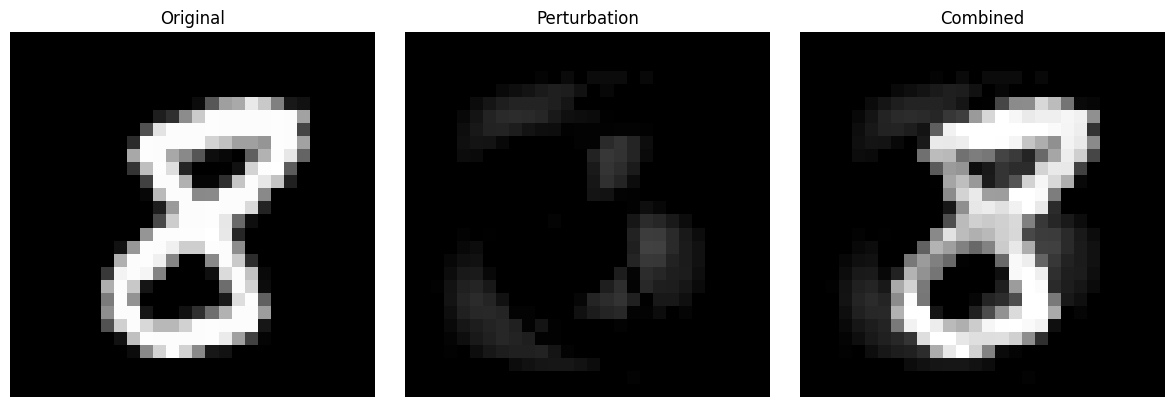

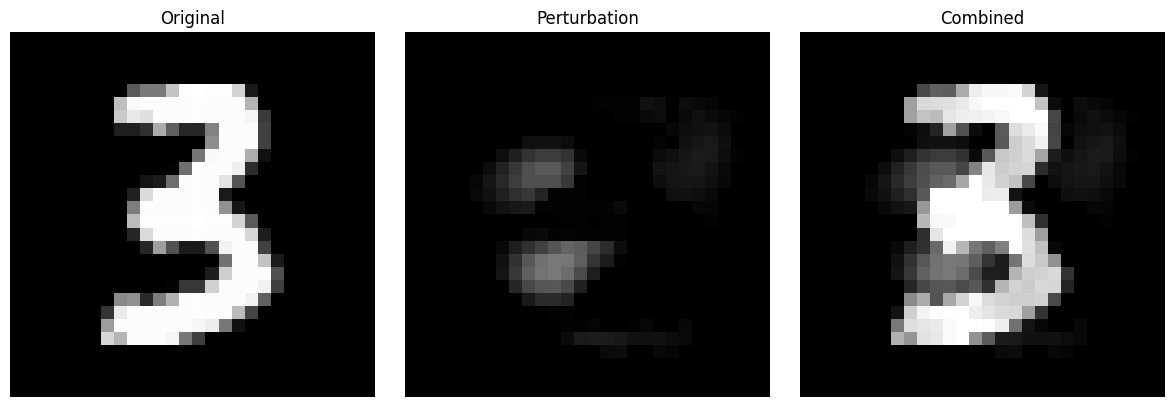

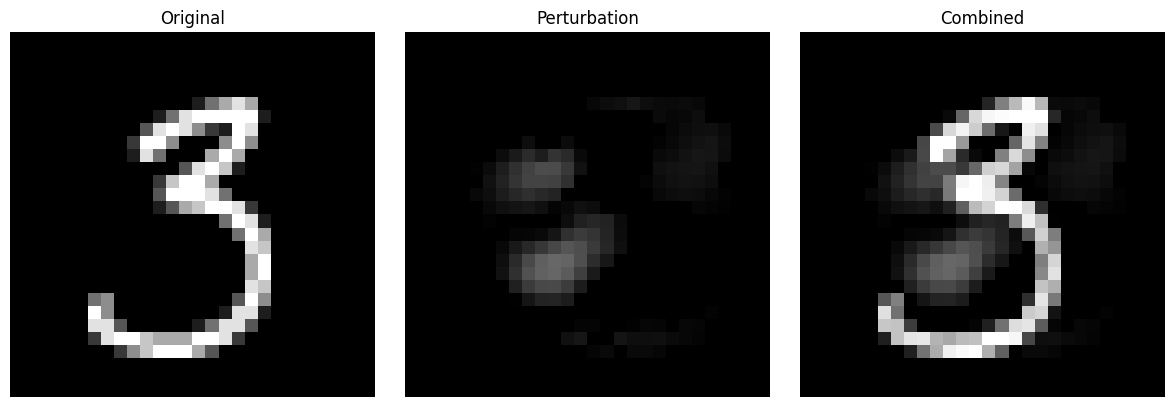

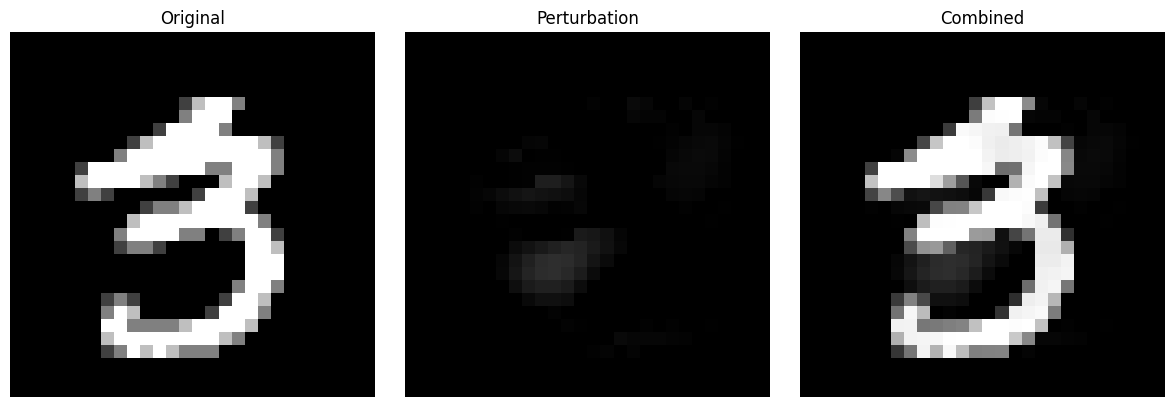

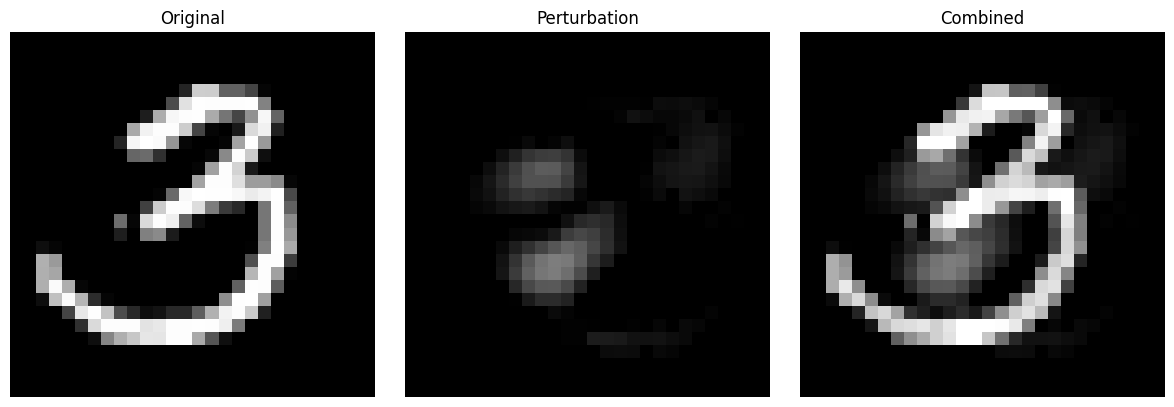

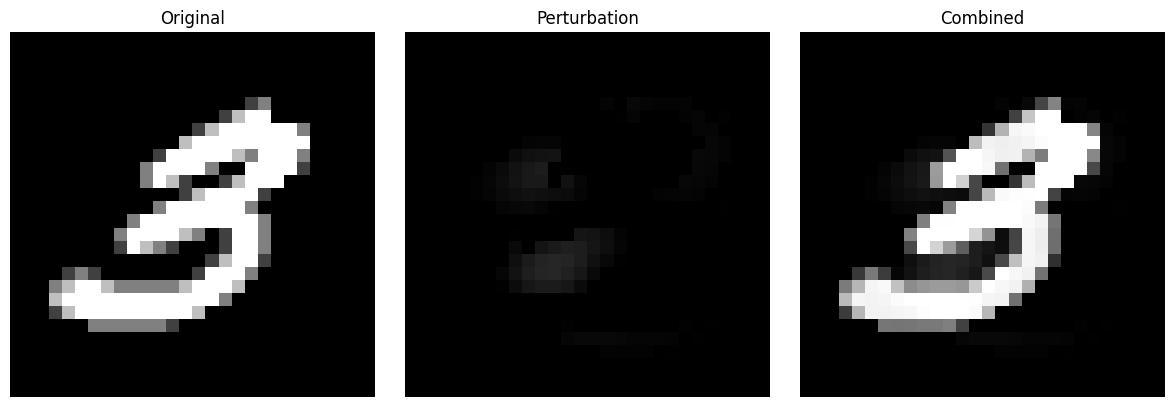

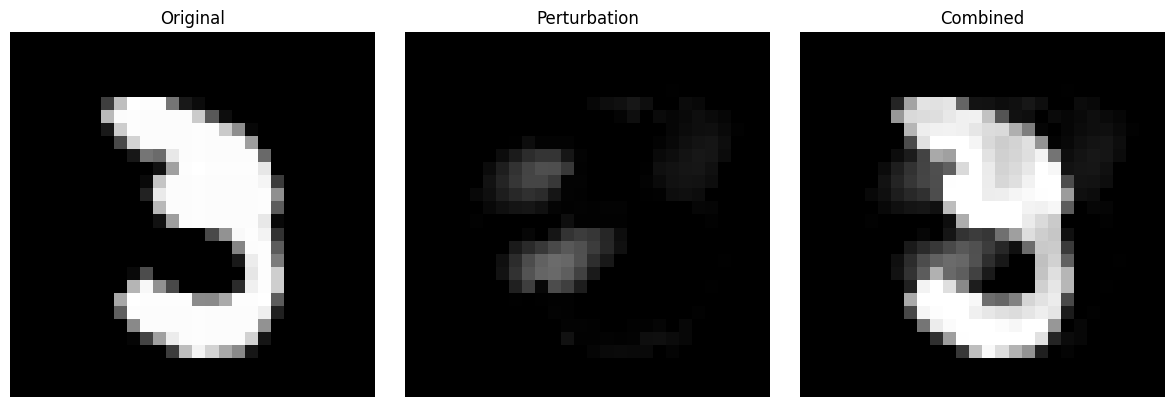

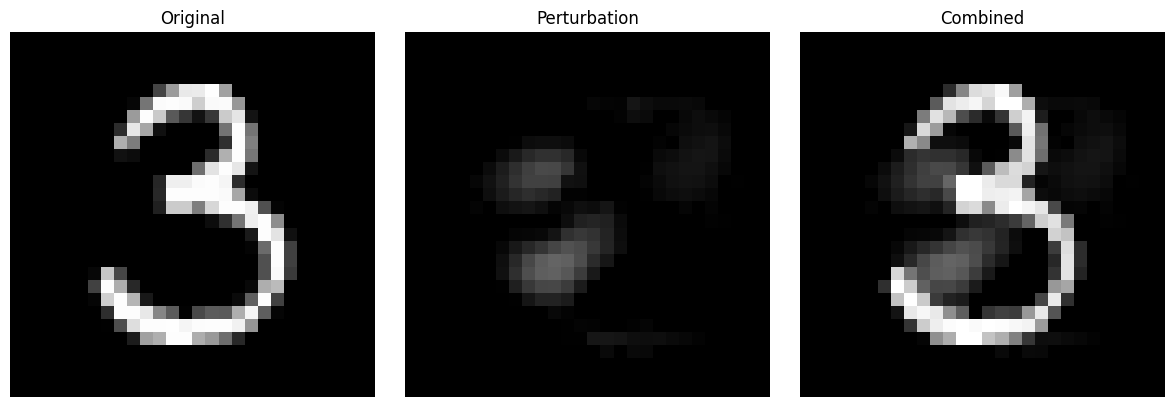

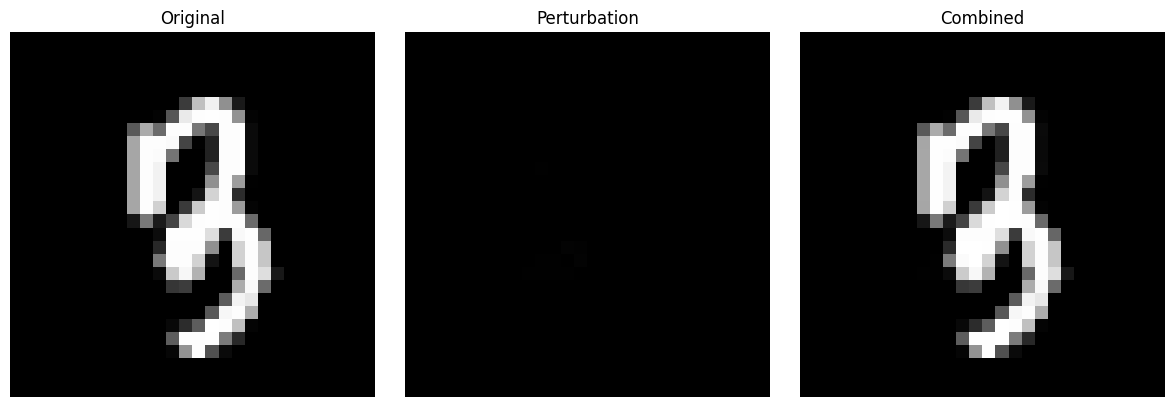

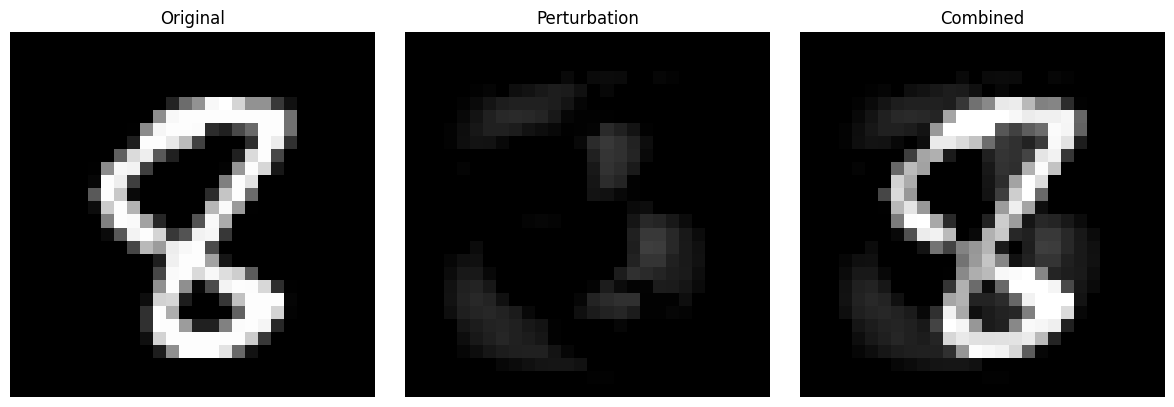

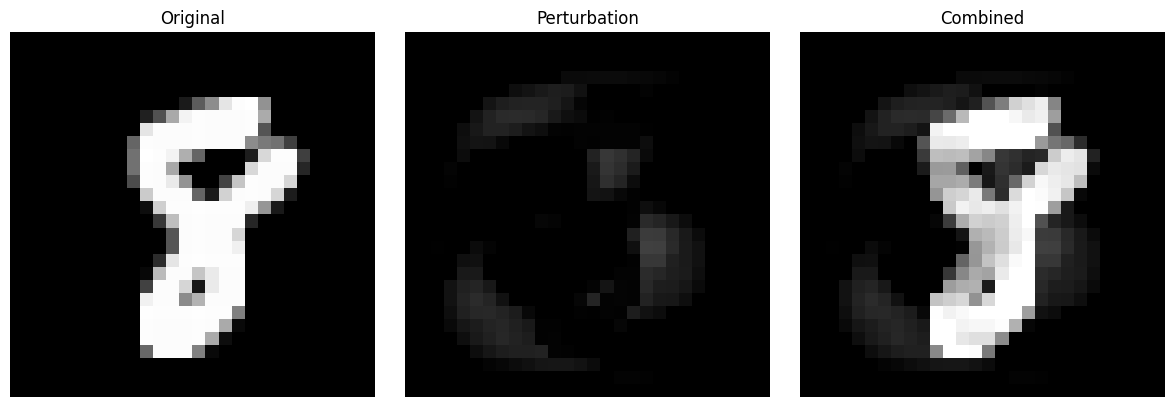

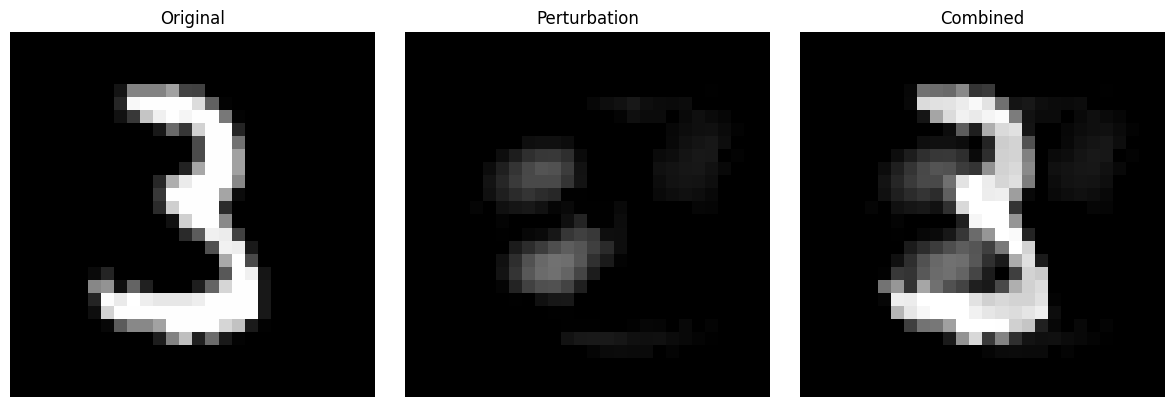

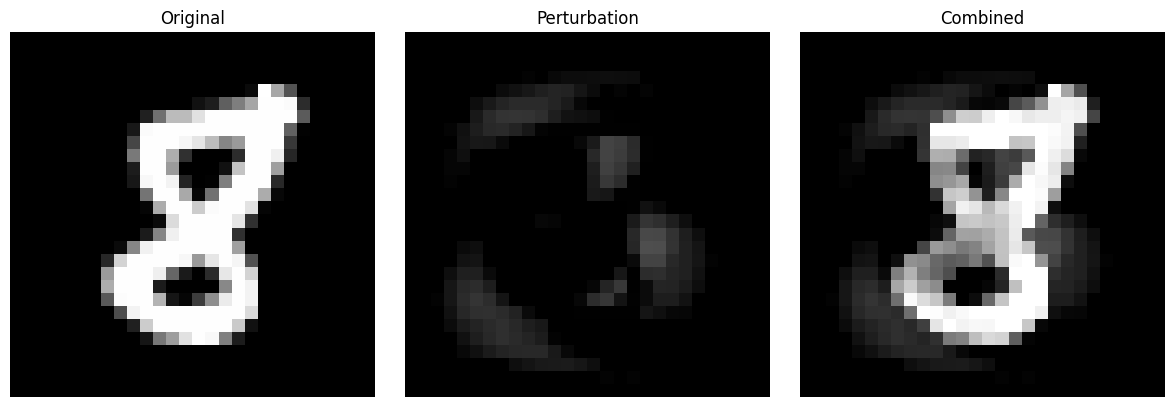

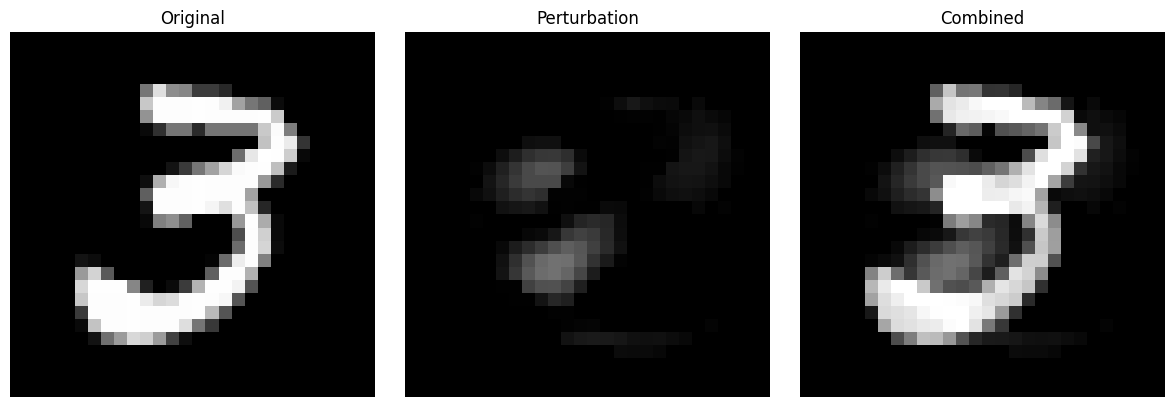

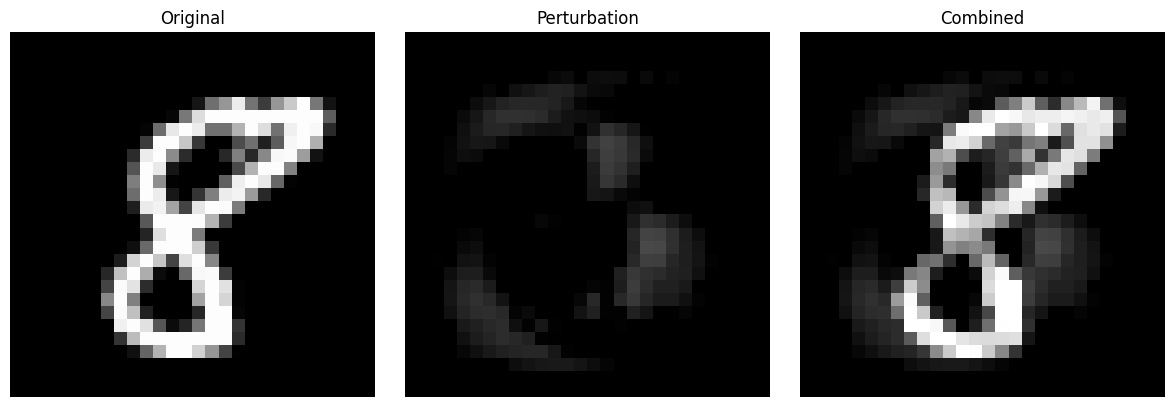

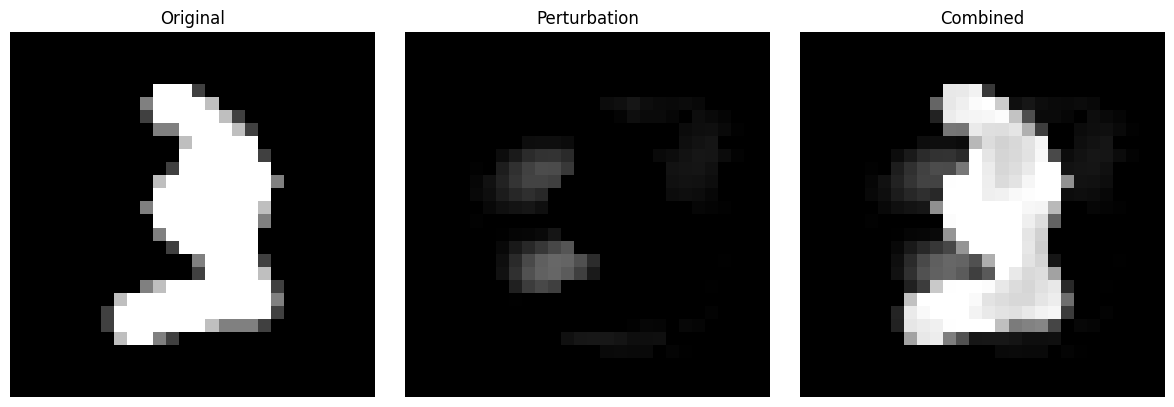

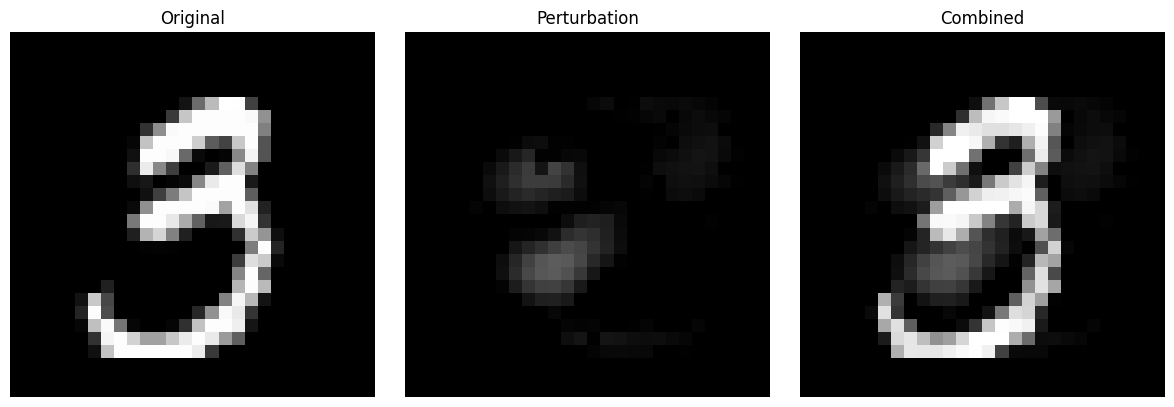

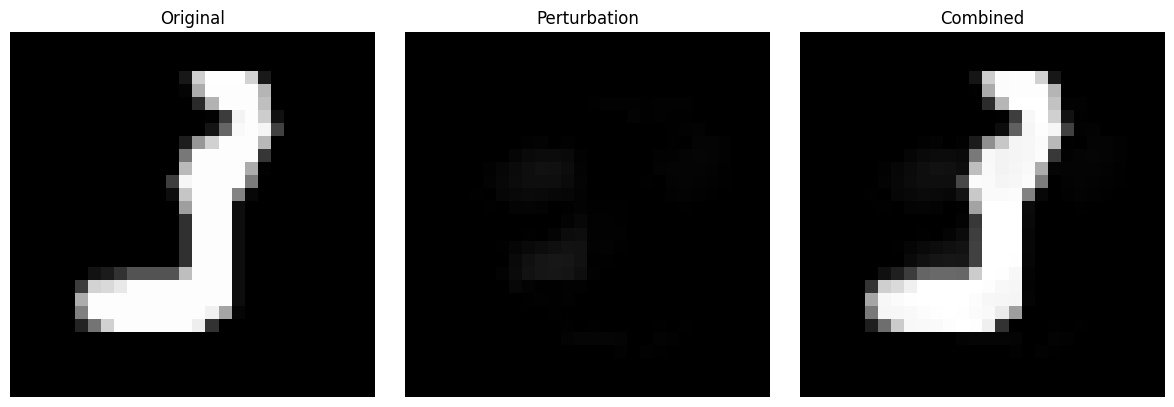

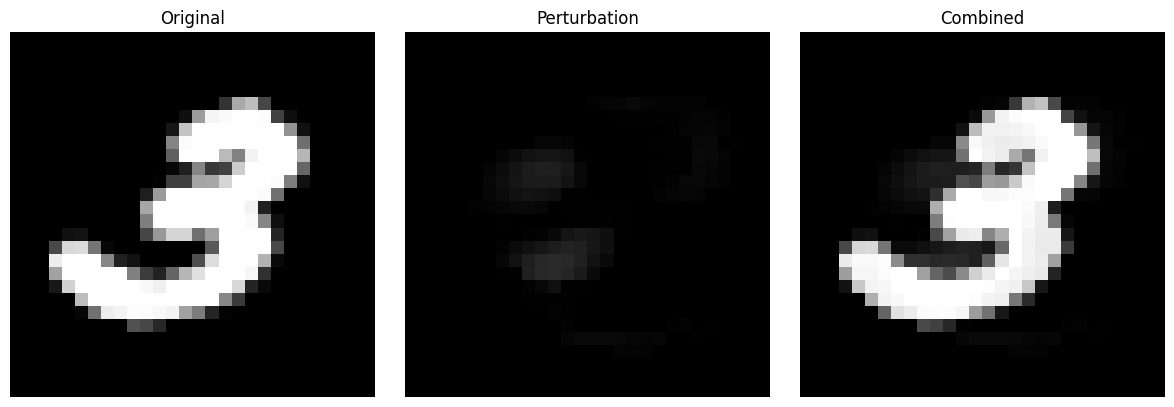

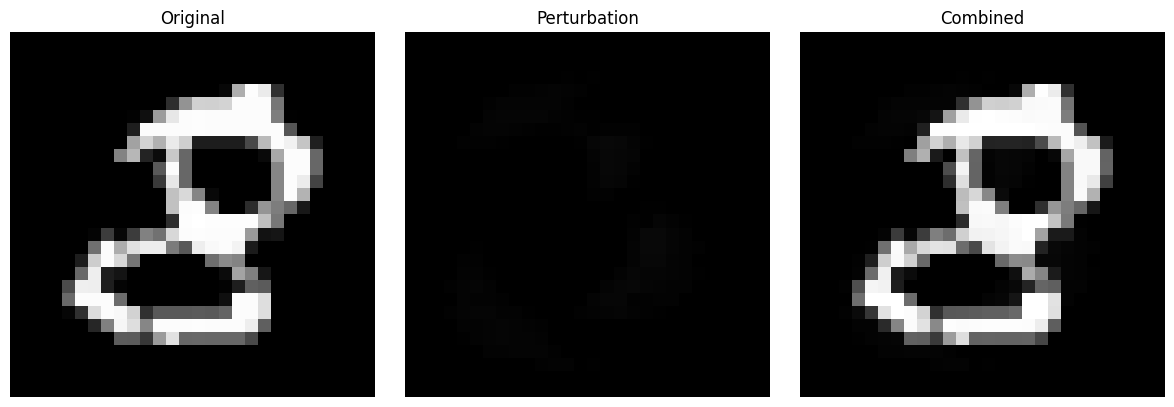

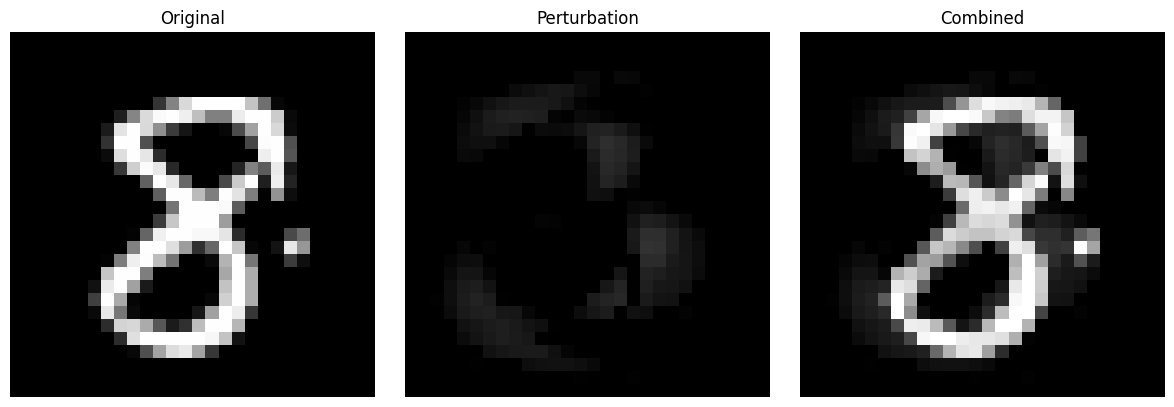

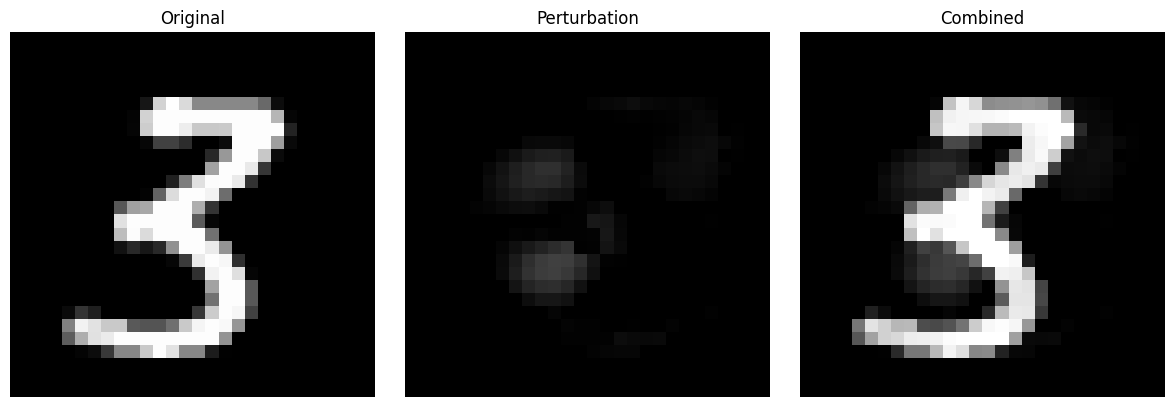

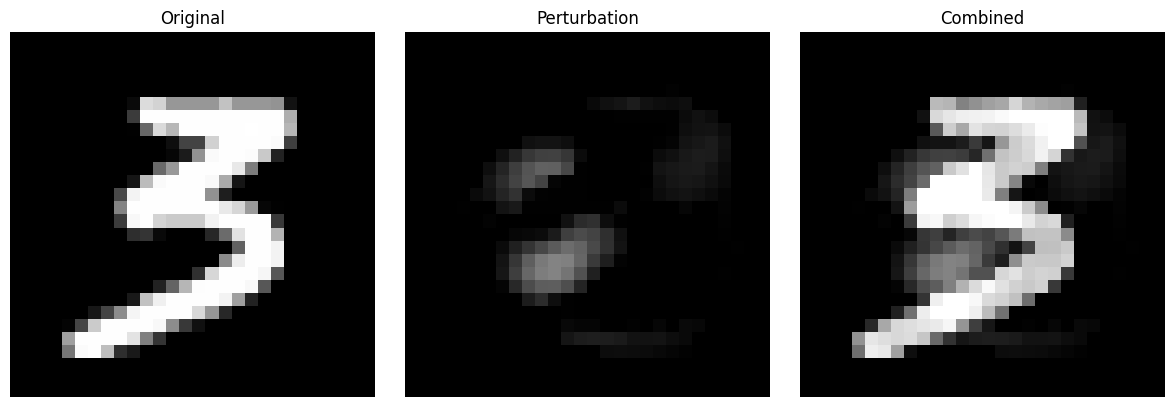

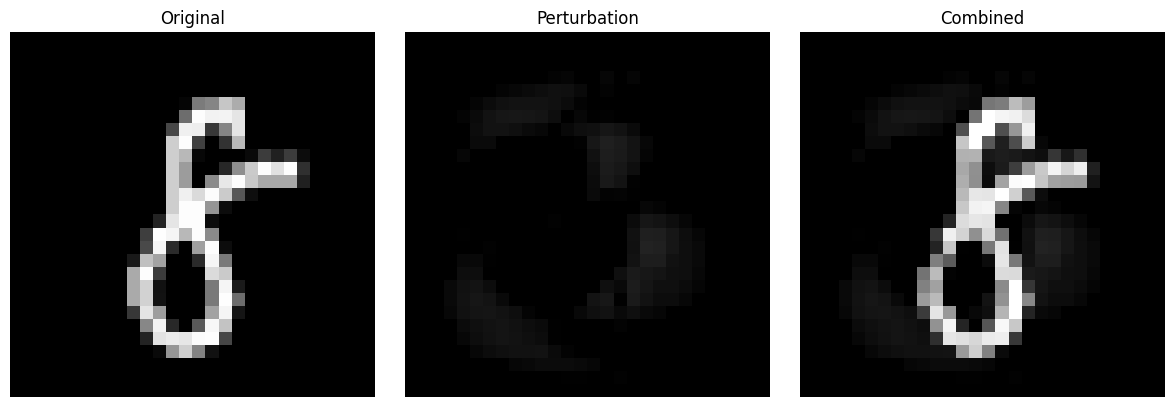

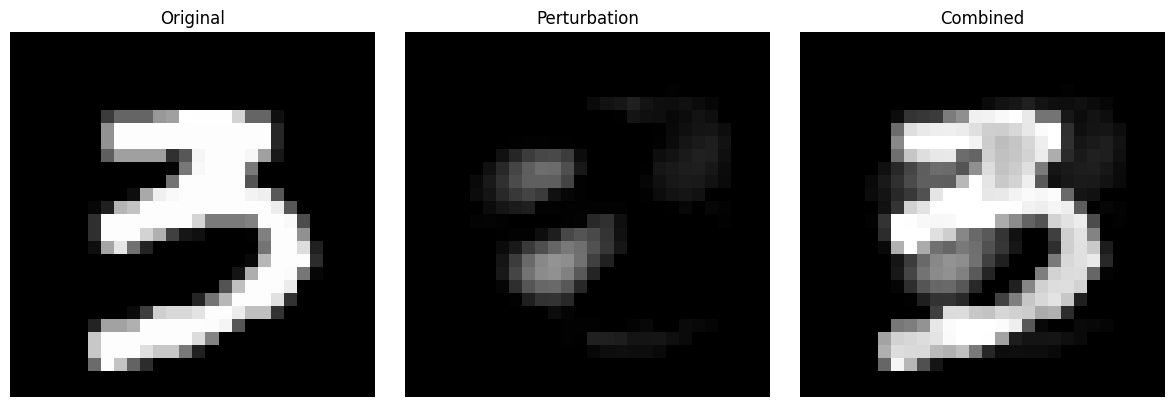

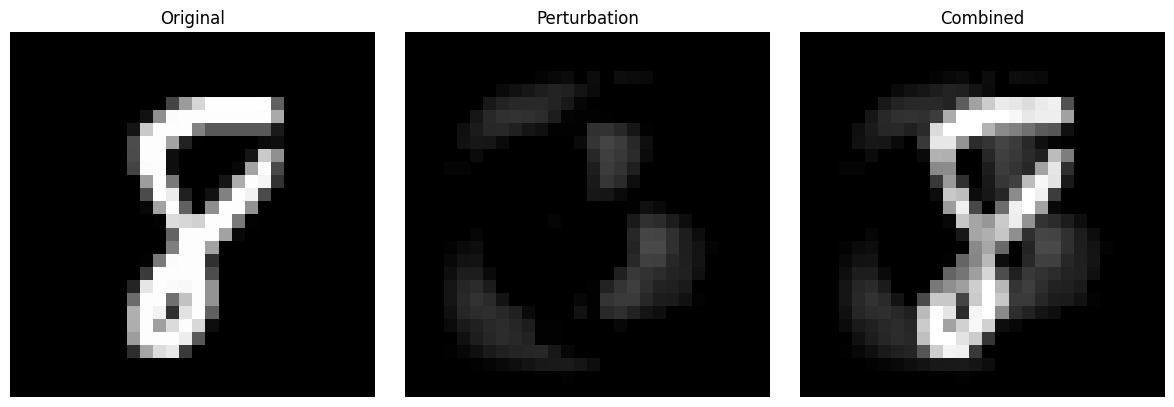

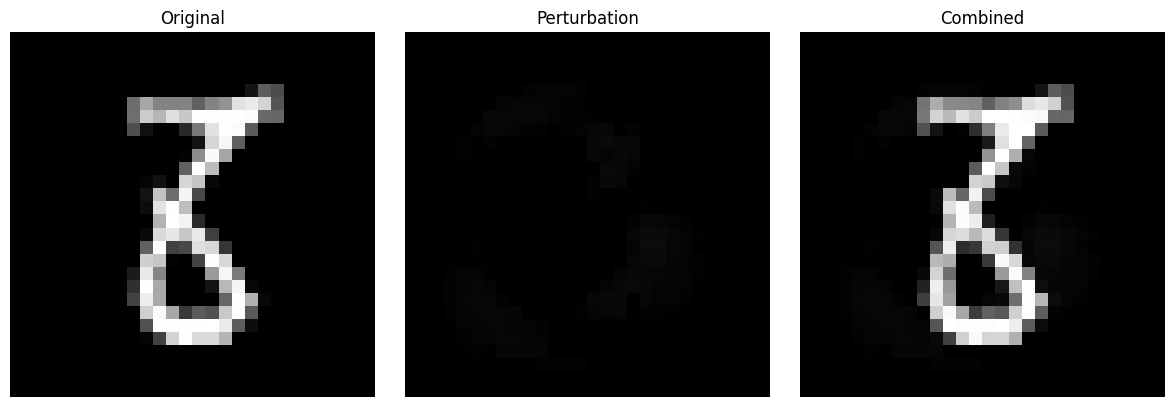

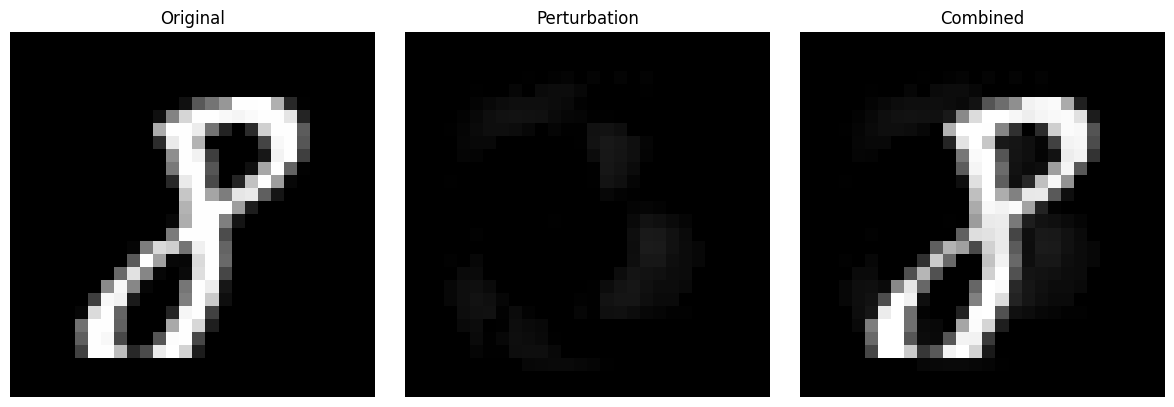

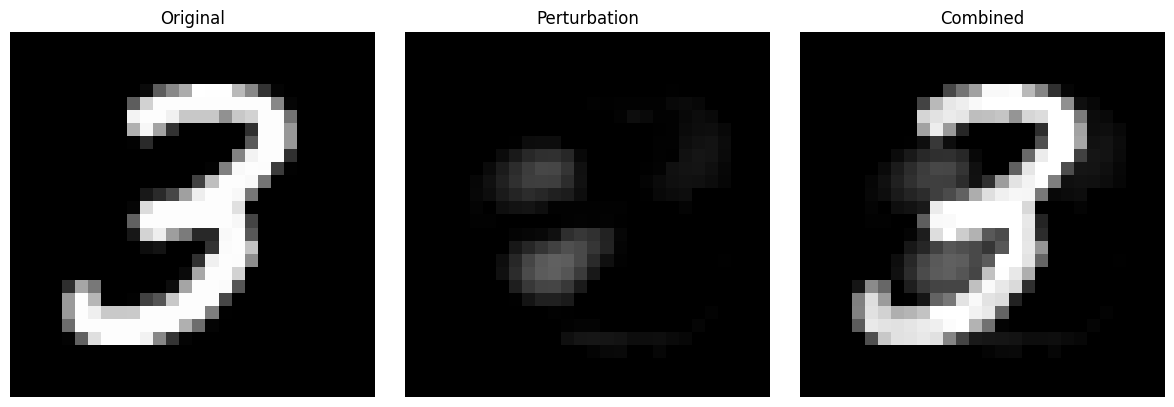

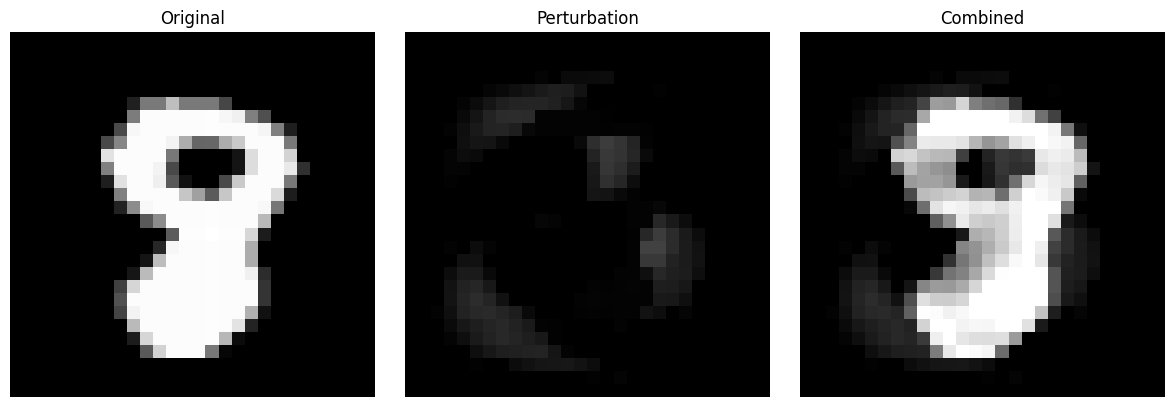

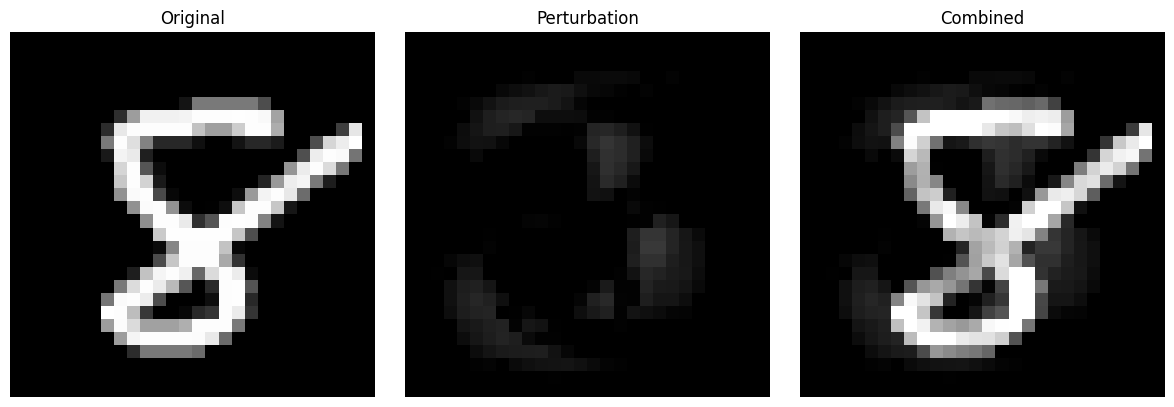

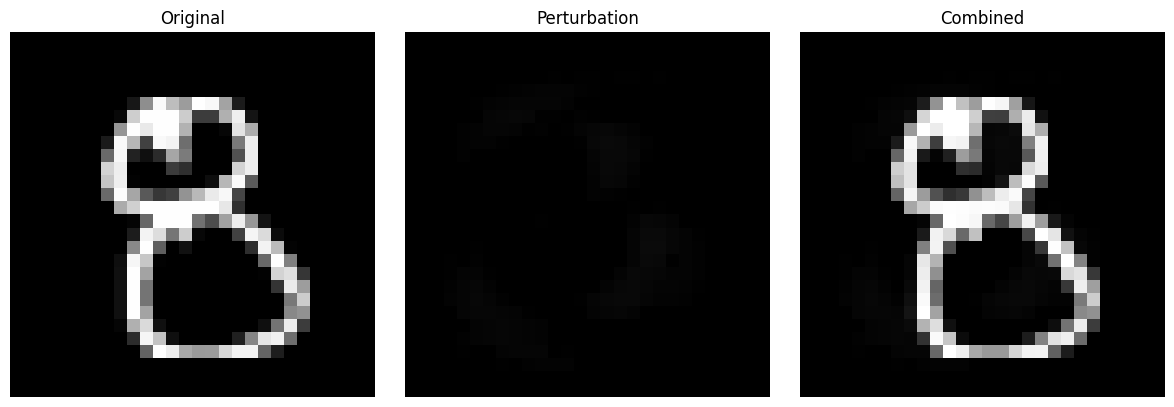

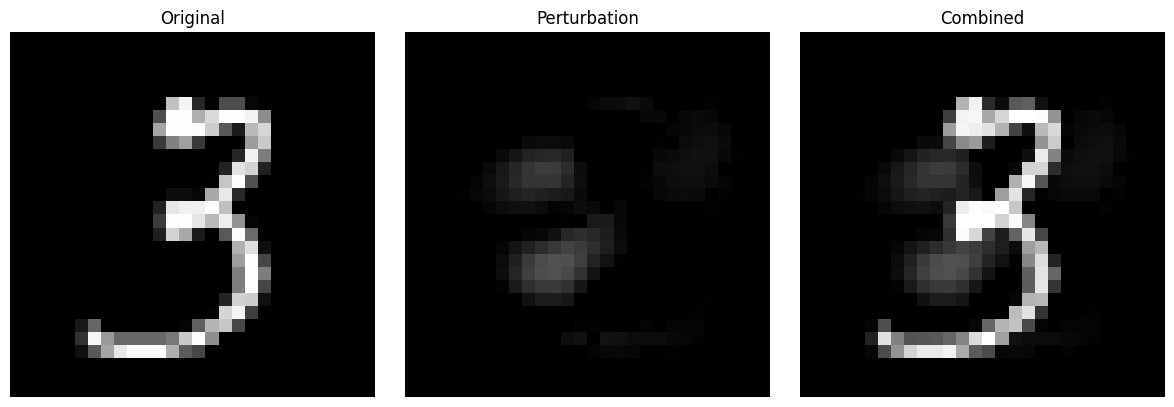

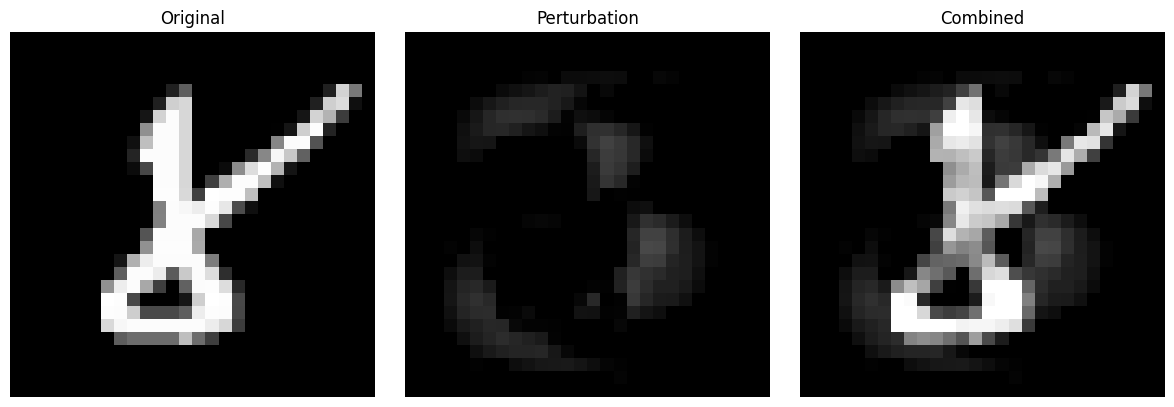

In [46]:
means = []

for i in range(50):
    num_epochs = 10000
    l2_reg = 0.75

    perturbation = torch.rand(X_train.size(1)) * 0.001
    perturbation.requires_grad = True

    opt = torch.optim.SGD([perturbation], lr=1e-1)

    Xb = X_train[i:i+1, :]
    yb = y_train[i:i+1]
    yb_pred_new = model(Xb).sign().detach().numpy()
    yb_pred_new

    sb = tqdm(range(num_epochs))
    tl = []
    for epoch in sb:
        new_Xb = torch.clamp(Xb + perturbation, 0.0, 1.0)
        new_yb = yb * -1
        loss = model.svm_loss(new_Xb, new_yb)

        l2_loss = perturbation.norm()
        total_loss = loss + l2_reg * l2_loss
        opt.zero_grad()
        total_loss.backward()
        opt.step()

        if epoch % 10 == 0:
            with torch.no_grad():
                pred = model(new_Xb).sign().detach().numpy()
                # print(pred != yb_pred_new, np.sum(pred != yb_pred_new))
                # break
                if np.sum(pred != yb_pred_new) >= len(pred):
                    print("Finished!")
                    break
                loss = model.svm_loss(Xb + perturbation, yb)
                tl.append(loss.item())
                sb.set_postfix(loss=tl[-1])

    Xb_np = Xb.detach().numpy().reshape(28,28)
    perturbation_np = perturbation.detach().numpy().reshape(28, 28)
    means.append(np.mean(perturbation_np.reshape(-1) ** 2))
    print(means[-1])
    import matplotlib.pyplot as plt

    # Create a row of 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original
    axes[0].imshow(Xb_np, cmap="gray", vmin=0, vmax=1)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Perturbation
    axes[1].imshow(perturbation_np, cmap="gray", vmin=0, vmax=1)
    axes[1].set_title("Perturbation")
    axes[1].axis("off")

    # Combined
    axes[2].imshow(Xb_np + perturbation_np, cmap="gray", vmin=0, vmax=1)
    axes[2].set_title("Combined")
    axes[2].axis("off")

    plt.tight_layout()
    plt.savefig(f'images/svm{str(i).zfill(2)}.png')

In [47]:
np.mean(means)

0.005418123

In [49]:
0.005418123/0.0008915822

6.076975291790259

In [ ]:
Xb_np = Xb.detach().numpy().reshape(28,28)
perturbation_np = perturbation.detach().numpy().reshape(28, 28)

import matplotlib.pyplot as plt

# Create a row of 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original
axes[0].imshow(Xb_np, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Original")
axes[0].axis("off")

# Perturbation
axes[1].imshow(perturbation_np, cmap="gray", vmin=0, vmax=1)
axes[1].set_title("Perturbation")
axes[1].axis("off")

# Combined
axes[2].imshow(Xb_np + perturbation_np, cmap="gray", vmin=0, vmax=1)
axes[2].set_title("Combined")
axes[2].axis("off")

plt.tight_layout()
plt.show()

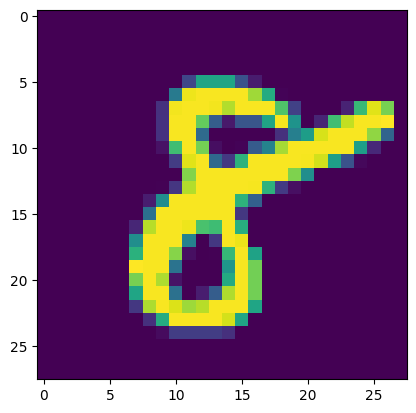

In [16]:
plt.imshow(Xb[:1].reshape((28,28)))

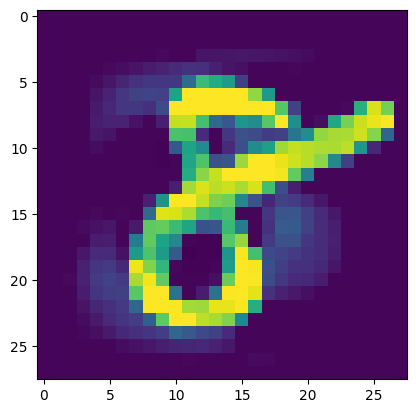

In [17]:
plt.imshow((Xb[:1] + perturbation.detach()).reshape((28,28)))

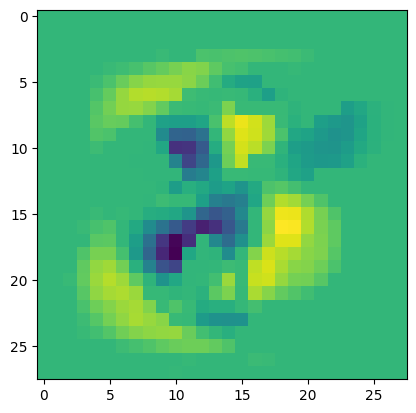

In [18]:
plt.imshow((perturbation.detach()).reshape((28,28)))

# Now to break CAL

# Now to break training


In [33]:
for param in model.parameters():
    param.requires_grad = True

C = 1.0

lr = 1e-2
num_epochs = 10

NUM_POISON_POINTS = 100

Xp = torch.rand((NUM_POISON_POINTS, X_train.size(1)))
yp = torch.Tensor([1] * (NUM_POISON_POINTS//2) + [-1] * (NUM_POISON_POINTS//2))
Xp.requires_grad = True


oldw = np.copy(model.w.detach().numpy())
oldb = np.copy(model.b.detach().numpy())
# dim = X_train.size(1)
# model = LinearSVM(dim, C=1.0).to(device)
optmodel = torch.optim.SGD(model.parameters(), lr=1e-4)
optpoison = torch.optim.SGD([Xp], lr=1e-1)

num_epochs = 500
sb = tqdm(range(num_epochs))
tl = []

for epoch in sb:
    Xb = torch.cat([X_train, Xp],dim=0)
    yb = torch.cat([y_train, yp], dim=0)

    # train the model stage
    loss = model.svm_loss(Xb, yb)
    optmodel.zero_grad()
    loss.backward()
    optmodel.step()

    # train the poison stage
    # new_Xb = torch.clamp(Xb, 0.0, 1.0)
    loss = -model.svm_loss(Xb, yb)
    optpoison.zero_grad()
    loss.backward()
    optpoison.step()
    with torch.no_grad():
        Xp = torch.clamp(Xp, 0.0, 1.0)

    if epoch % 10 == 0:
        with torch.no_grad():
            loss = model.svm_loss(X_val, y_val)
            tl.append(loss.item())
            sb.set_postfix(loss=tl[-1])

neww = model.w.detach().numpy()
newb = model.b.detach().numpy()
print(neww - oldw)

100%|██████████| 500/500 [00:02<00:00, 172.27it/s, loss=0.323]

[-4.16868279e-05  4.42332748e-06 -4.04657912e-05 -1.33730064e-05
 -7.26606231e-06  8.88902105e-06  1.64149096e-05 -4.27795458e-05
 -1.33696740e-05  1.38467658e-06 -4.56342968e-06  1.24682892e-05
  1.38444302e-05 -3.12023849e-06  3.89931374e-05  8.93797551e-06
  4.96213761e-05 -1.08397217e-06  1.08508830e-05 -3.23262211e-05
 -1.86180932e-05 -1.53441142e-05 -2.92278128e-05 -2.66719435e-05
 -1.41900591e-05 -4.80965100e-05  2.14744068e-06  1.81049527e-05
 -3.73163784e-05  4.48439096e-06 -4.31298395e-06  1.00063335e-05
 -1.14215072e-06 -8.27599506e-05 -9.79057222e-06 -1.23997916e-06
  3.32828495e-06 -1.76671019e-05  1.48961699e-05  6.57064957e-05
  5.52639176e-05 -3.84399318e-05  2.61337846e-06  1.85758399e-05
 -3.93016671e-05  2.52220198e-05 -4.39053110e-06  2.15528416e-05
 -1.53825313e-05 -2.73757032e-05 -5.53559730e-05 -6.38100319e-05
 -1.24554645e-05  5.79426560e-05 -3.87156069e-05  3.70728085e-05
  3.01110049e-05 -1.09267596e-04  1.54998997e-05 -4.42716264e-05
 -8.02513387e-06 -2.84703

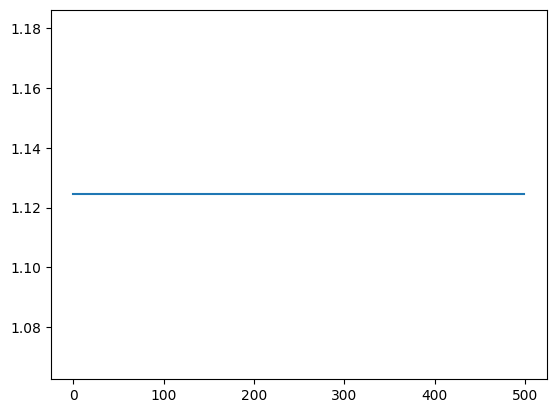

In [32]:
tlnp = np.array(tl)
# tlnpdiff = tlnp[1:] - tlnp[:-1]
plt.plot(tlnp)

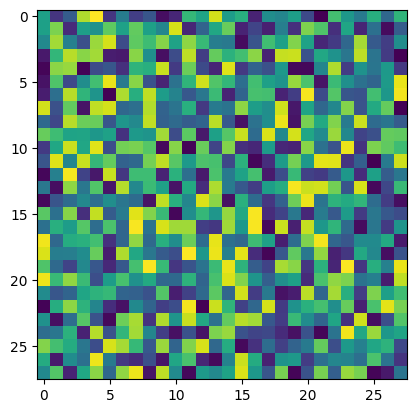

In [31]:
plt.imshow(Xp[1:2].detach().numpy().reshape((28,28)))

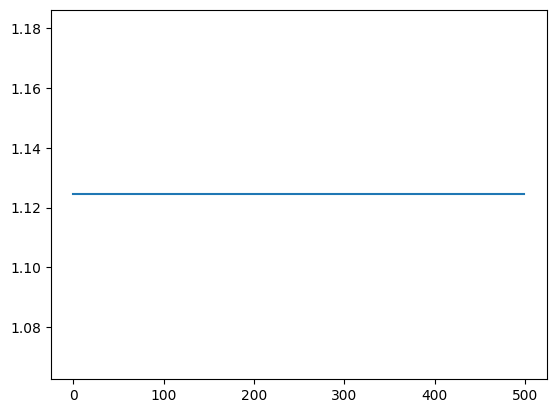

In [22]:
plt.plot(tl)

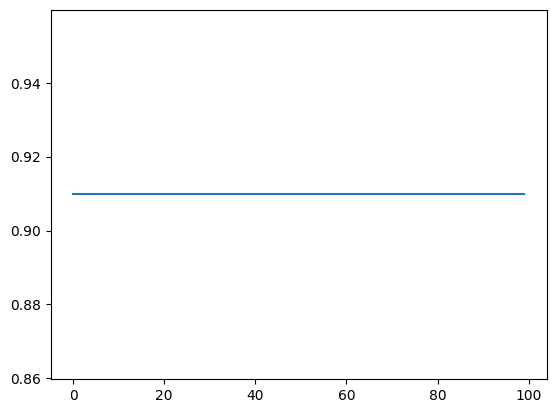